In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [3]:
url = '/content/drive/MyDrive/Colab Notebooks/Fashion_Retail_Sales.csv'
data = pd.read_csv(url, encoding='ISO-8859-1', na_values='?')

In [4]:
data.shape

(3400, 6)

In [5]:
data.head()

,Customer Reference ID,Item Purchased,Purchase Amount (USD),Date Purchase,Review Rating,Payment Method
0,4018,Handbag,4619.0,2023-02-05,NaN,Credit Card
1,4115,Tunic,2456.0,2023-07-11,2.0,Credit Card
2,4019,Tank Top,2102.0,2023-03-23,4.1,Cash
3,4097,Leggings,3126.0,2023-03-15,3.2,Cash
4,3997,Wallet,3003.0,2022-11-27,4.7,Cash


In [6]:
data.describe()

,Customer Reference ID,Purchase Amount (USD),Review Rating
count,3400.000000,2750.000000,3076.000000
mean,4039.660588,156.709818,2.999057
std,48.122583,419.536669,1.156505
min,3957.000000,10.000000,1.000000
25%,3997.000000,57.000000,2.000000
50%,4040.000000,110.000000,3.000000
75%,4081.000000,155.750000,4.000000
max,4122.000000,4932.000000,5.000000


In [7]:
data.dropna(inplace=True)

In [8]:
print(data.isna().sum())

Customer Reference ID    0
Item Purchased           0
Purchase Amount (USD)    0
Date Purchase            0
Review Rating            0
Payment Method           0
dtype: int64


In [9]:
#Нормализация количественных данных
from sklearn.preprocessing import StandardScaler
numerical_columns = data.select_dtypes(include=["int64", "float64"]).drop(columns=["Customer Reference ID"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numerical_columns)

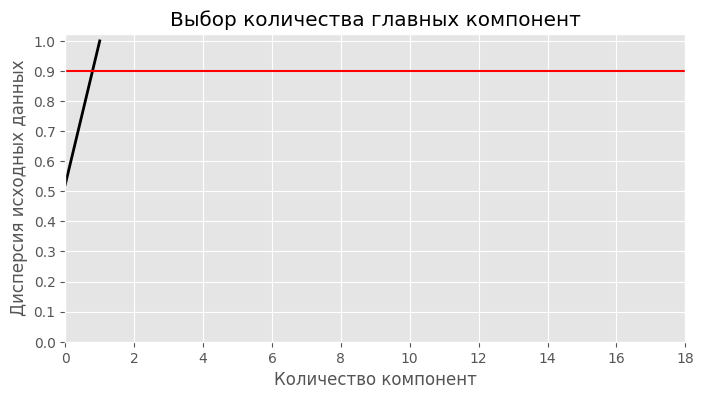

In [10]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_scaled)
plt.figure(figsize=(8,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.title('Выбор количества главных компонент')
plt.xlabel('Количество компонент')
plt.ylabel('Дисперсия исходных данных')
plt.xlim(0, 18)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axhline(0.9, c='r')
plt.show()
n_components_90 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.9) + 1

In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)
feature_names = ['Purchase Amount (USD)', 'Review Rating']

print("Форма исходного массива: {}".format(str(X_scaled.shape)))
print("Форма массива после сокращения размерности: {}".format(str(X_pca.shape)))

columns = X_scaled.columns if isinstance(X_scaled, pd.DataFrame) else feature_names

components_df = pd.DataFrame(
    pca.components_,
    columns=columns,
    index=[f'Компонента {i+1}' for i in range(pca.n_components_)]
)

Форма исходного массива: (2487, 2)
Форма массива после сокращения размерности: (2487, 2)


In [12]:
def show_selected_features(pca, numerical_columns):
    import numpy as np

    # Получаем компоненты PCA
    components = pca.components_

    # Для каждой компоненты находим индекс признака с максимальным весом
    top_features_indices = [np.argmax(np.abs(component)) for component in components]

    # Удаляем дубликаты, сохраняя порядок
    unique_indices = []
    for index in top_features_indices:
        if index not in unique_indices:
            unique_indices.append(index)

    # Преобразуем названия признаков в список
    column_names = numerical_columns.columns.tolist()

    # Получаем названия признаков
    selected_features = [column_names[i] for i in unique_indices]

    print("Выбранные ключевые признаки:")
    for feature in selected_features:
        print(feature)
show_selected_features(pca, numerical_columns)

Выбранные ключевые признаки:
Purchase Amount (USD)
Review Rating


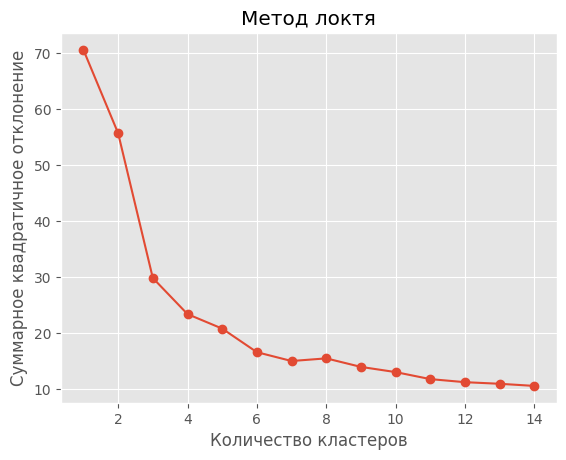

In [13]:
#Метод локтя
from sklearn.cluster import KMeans
inertia = []
for k in range(1, 15):
 kmeans = KMeans(n_clusters=k, random_state=1).fit(X_pca)
 inertia.append(np.sqrt(kmeans.inertia_))
plt.figure()
plt.plot(range(1, 15), inertia, marker='o');
plt.title('Метод локтя')
plt.xlabel('Количество кластеров')
plt.ylabel('Суммарное квадратичное отклонение')
plt.show()

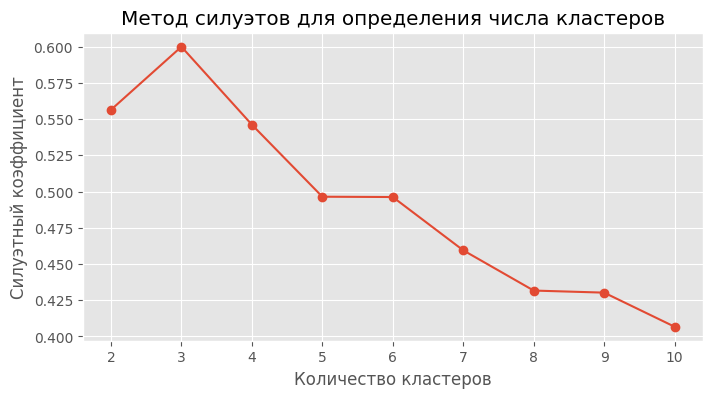

Оптимальное количество кластеров по методу силуэтов: 3


In [14]:
#Метод силуэтов
from sklearn.metrics import silhouette_score
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 4))
plt.plot(K, silhouette_scores, marker='o')
plt.title('Метод силуэтов для определения числа кластеров')
plt.xlabel('Количество кластеров')
plt.ylabel('Силуэтный коэффициент')
plt.grid(True)
plt.show()

best_k = K[np.argmax(silhouette_scores)]
print(f"Оптимальное количество кластеров по методу силуэтов: {best_k}")

<ipython-input-15-0e5b198a6b2c>:11: UserWarning: Mismatched number of handles and labels: len(handles) = 3 len(labels) = 5
  legend1 = plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title="Кластеры")


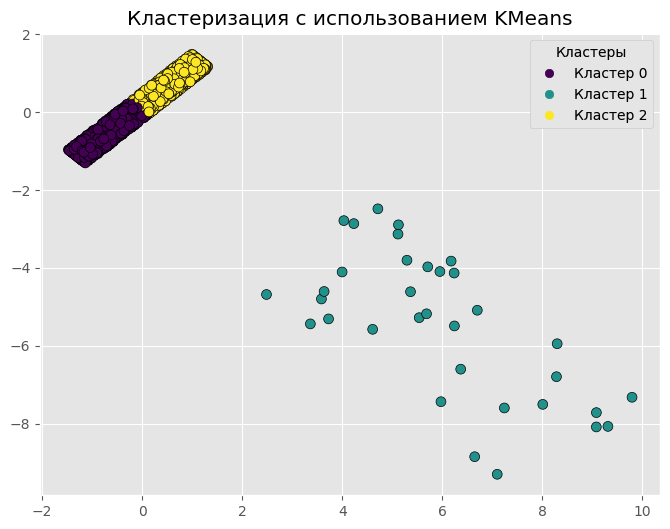

Cluster
0          1260
1            34
2          1193
Name: count, dtype: int64
Empty DataFrame
Columns: []
Index: [0, 1, 2]


In [15]:
#K-Means метод силуэтов
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=1)
labels = kmeans.fit_predict(X_pca)

legend_labels = [f'Кластер {i}' for i in range(5)]

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', edgecolors='k', s=50)
legend1 = plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title="Кластеры")
plt.gca().add_artist(legend1)
plt.title('Кластеризация с использованием KMeans')
plt.show()

df_clusters = pd.DataFrame({'Cluster': labels})
print(df_clusters.value_counts().sort_index())
cluster_means = df_clusters.groupby('Cluster').mean()
print(cluster_means)

In [16]:
data['Cluster'] = kmeans.labels_
numeric_columns = data.select_dtypes(include=['number']).columns
cluster_stats = data.groupby('Cluster')[numeric_columns].mean()
print(cluster_stats)

         Customer Reference ID  Purchase Amount (USD)  Review Rating  Cluster
Cluster                                                                      
0                  4040.230952             104.571429       2.012937      0.0
1                  4042.029412            3290.176471       3.402941      1.0
2                  4040.166806             107.673093       4.002347      2.0


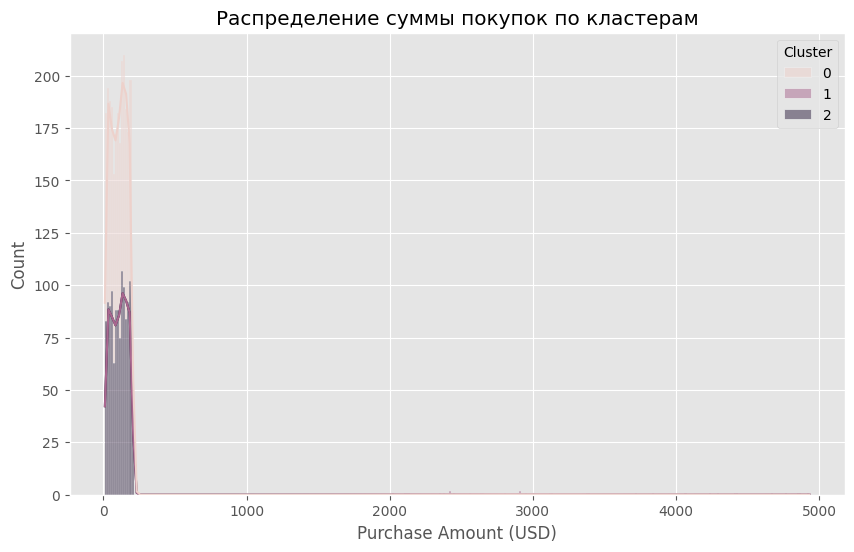

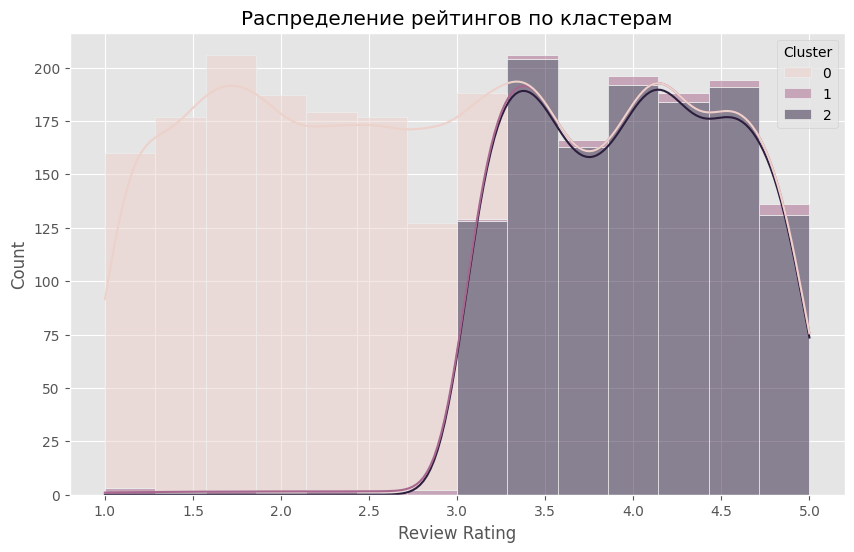

In [17]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='Purchase Amount (USD)', hue='Cluster', kde=True, multiple='stack')

plt.title('Распределение суммы покупок по кластерам')
plt.show()

# Гистограмма для рейтингов по кластерам
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='Review Rating', hue='Cluster', kde=True, multiple='stack')
plt.title('Распределение рейтингов по кластерам')
plt.show()

In [18]:
category_proportions = data.groupby('Cluster')['Item Purchased'].value_counts(normalize=True).unstack(fill_value=0)

# Выводим пропорции товаров по кластерам
print(category_proportions)

Item Purchased  Backpack      Belt    Blazer    Blouse     Boots    Bowtie  \
Cluster                                                                      
0               0.021429  0.024603  0.018254  0.019841  0.014286  0.015873   
1               0.000000  0.029412  0.029412  0.000000  0.058824  0.029412   
2               0.020956  0.027661  0.021794  0.020117  0.021794  0.012573   

Item Purchased  Camisole  Cardigan      Coat     Dress  ...  Swimsuit  \
Cluster                                                 ...             
0               0.027778  0.023016  0.018254  0.017460  ...  0.017460   
1               0.000000  0.029412  0.000000  0.000000  ...  0.029412   
2               0.020956  0.022632  0.022632  0.017603  ...  0.019279   

Item Purchased   T-shirt  Tank Top       Tie  Trench Coat  Trousers     Tunic  \
Cluster                                                                         
0               0.018254  0.022222  0.015079     0.017460  0.019048  0.025397   


In [19]:
# Оценка метрик качества для K-Means
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.cluster import adjusted_rand_score

silhouette_kmeans = silhouette_score(X_pca, labels)
calinski_kmeans = calinski_harabasz_score(X_pca, labels)
davies_bouldin_kmeans = davies_bouldin_score(X_pca, labels)

print("K-Means Метрики качества:")
print(f"Силуэтный коэффициент: {silhouette_kmeans}")
print(f"Индекс Калински-Харабаса: {calinski_kmeans}")
print(f"Индекс Дэвиса-Боулдина: {davies_bouldin_kmeans}")

K-Means Метрики качества:
Силуэтный коэффициент: 0.5999922354456677
Индекс Калински-Харабаса: 5681.087943743073
Индекс Дэвиса-Боулдина: 0.47222594705567794


<ipython-input-20-795873bd8ad0>:11: UserWarning: Mismatched number of handles and labels: len(handles) = 4 len(labels) = 5
  legend1 = plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title="Кластеры")


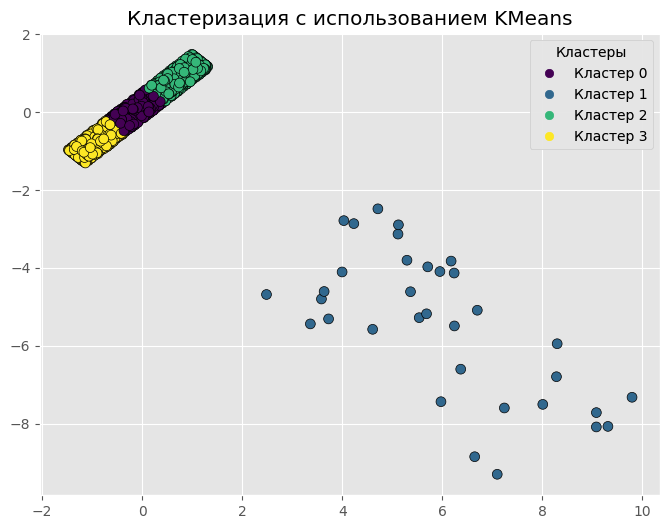

Cluster
0          813
1           34
2          861
3          779
Name: count, dtype: int64
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3]


In [20]:
#K-Means метод локтя
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=1)
labels = kmeans.fit_predict(X_pca)

legend_labels = [f'Кластер {i}' for i in range(5)]

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', edgecolors='k', s=50)
legend1 = plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title="Кластеры")
plt.gca().add_artist(legend1)
plt.title('Кластеризация с использованием KMeans')
plt.show()

df_clusters = pd.DataFrame({'Cluster': labels})
print(df_clusters.value_counts().sort_index())
cluster_means = df_clusters.groupby('Cluster').mean()
print(cluster_means)

In [21]:
# Оценка метрик качества для K-Means метод локтя
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.cluster import adjusted_rand_score

silhouette_kmeans = silhouette_score(X_pca, labels)
calinski_kmeans = calinski_harabasz_score(X_pca, labels)
davies_bouldin_kmeans = davies_bouldin_score(X_pca, labels)

print("K-Means Метрики качества:")
print(f"Силуэтный коэффициент: {silhouette_kmeans}")
print(f"Индекс Калински-Харабаса: {calinski_kmeans}")
print(f"Индекс Дэвиса-Боулдина: {davies_bouldin_kmeans}")

K-Means Метрики качества:
Силуэтный коэффициент: 0.5461992746353259
Индекс Калински-Харабаса: 6667.114318874422
Индекс Дэвиса-Боулдина: 0.5080438286828854


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


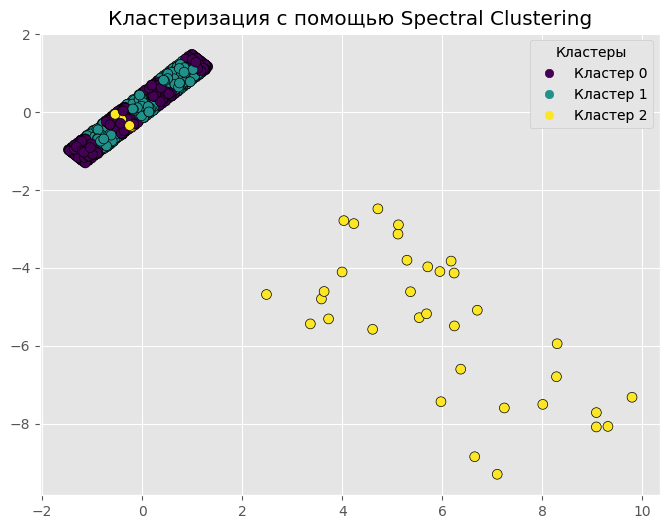

In [22]:
#Spectral clustering метод силуэтов
from sklearn.cluster import SpectralClustering
n_clusters = 3
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)

clusters = spectral.fit_predict(X_pca)

# Визуализируем результат
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', edgecolors='k', s=50)

legend_labels = [f"Кластер {i}" for i in range(n_clusters)]
legend1 = plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title="Кластеры")
plt.gca().add_artist(legend1)
plt.title("Кластеризация с помощью Spectral Clustering")
plt.show()

In [23]:
data['Cluster'] = clusters

cluster_stats = data.groupby('Cluster')[numeric_columns].mean()

print(cluster_stats)

         Customer Reference ID  Purchase Amount (USD)  Review Rating  Cluster
Cluster                                                                      
0                  4041.489380             104.627867       2.757944      0.0
1                  4039.042798             107.411523       3.220165      1.0
2                  4039.673684            1246.610526       2.823158      2.0


In [24]:
category_proportions = data.groupby('Cluster')['Item Purchased'].value_counts(normalize=True).unstack(fill_value=0)

# Выводим пропорции товаров по кластерам
print(category_proportions)

Item Purchased  Backpack      Belt    Blazer   Blouse     Boots    Bowtie  \
Cluster                                                                     
0               0.026338  0.025489  0.016992  0.02209  0.019541  0.011895   
1               0.015638  0.027160  0.022222  0.01893  0.017284  0.017284   
2               0.021053  0.021053  0.031579  0.00000  0.021053  0.010526   

Item Purchased  Camisole  Cardigan      Coat     Dress  ...  Swimsuit  \
Cluster                                                 ...             
0               0.028037  0.023789  0.014444  0.012744  ...  0.015293   
1               0.020576  0.023045  0.026337  0.021399  ...  0.020576   
2               0.021053  0.010526  0.010526  0.021053  ...  0.031579   

Item Purchased   T-shirt  Tank Top       Tie  Trench Coat  Trousers     Tunic  \
Cluster                                                                         
0               0.019541  0.023789  0.016992     0.016992  0.011895  0.028887   
1    

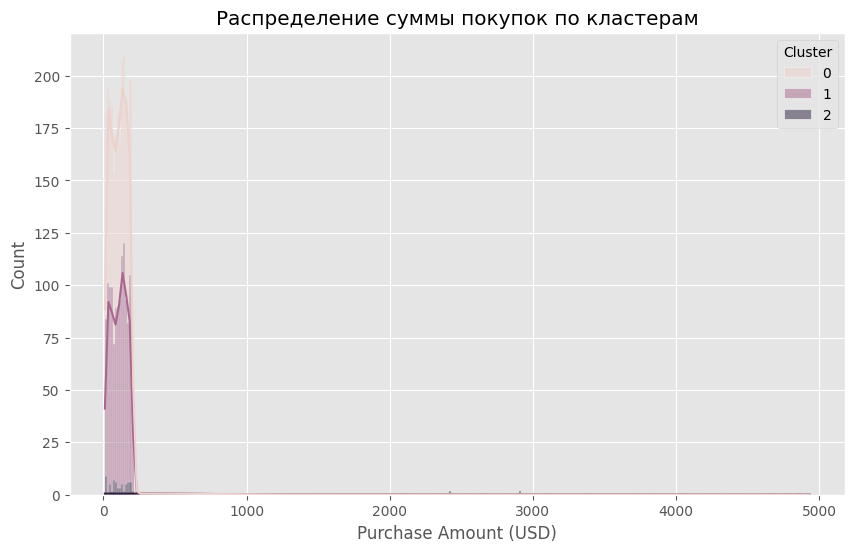

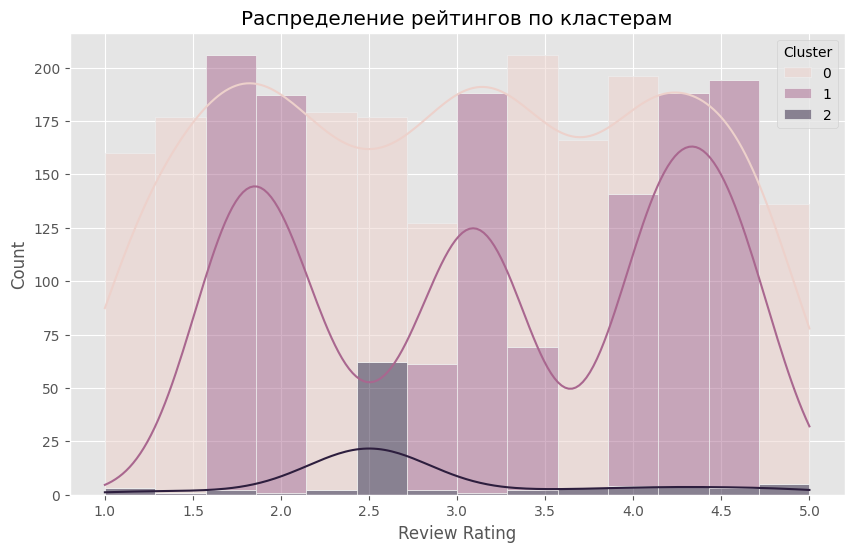

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='Purchase Amount (USD)', hue='Cluster', kde=True, multiple='stack')
plt.title('Распределение суммы покупок по кластерам')
plt.show()

# Гистограмма для рейтингов по кластерам
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='Review Rating', hue='Cluster', kde=True, multiple='stack')
plt.title('Распределение рейтингов по кластерам')
plt.show()

In [26]:
# Оценка метрик качества для Spectral Clustering
silhouette_spectral = silhouette_score(X_pca, clusters)
calinski_spectral = calinski_harabasz_score(X_pca, clusters)
davies_bouldin_spectral = davies_bouldin_score(X_pca, clusters)

print("\nSpectral Clustering Метрики качества:")
print(f"Силуэтный коэффициент: {silhouette_spectral}")
print(f"Индекс Калински-Харабаса: {calinski_spectral}")
print(f"Индекс Дэвиса-Боулдина: {davies_bouldin_spectral}")


Spectral Clustering Метрики качества:
Силуэтный коэффициент: 0.028977827561429678
Индекс Калински-Харабаса: 268.17756311854197
Индекс Дэвиса-Боулдина: 3.4374077420552687


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


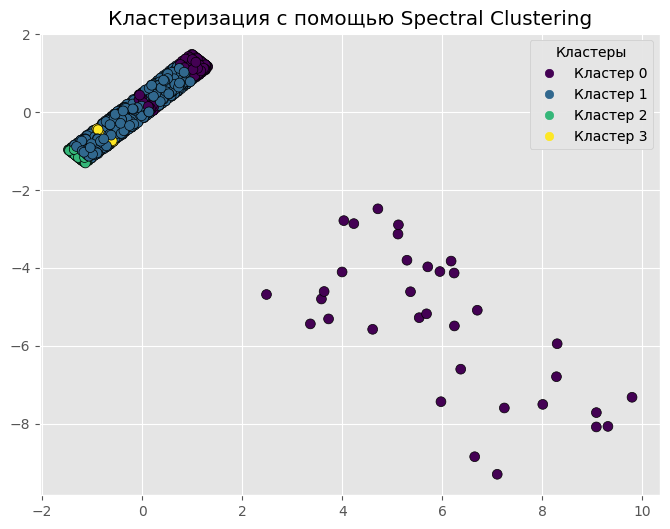

In [27]:
#Spectral clustering метод локтя
from sklearn.cluster import SpectralClustering
n_clusters = 4
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)

clusters = spectral.fit_predict(X_pca)

# Визуализируем результат
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', edgecolors='k', s=50)

legend_labels = [f"Кластер {i}" for i in range(n_clusters)]
legend1 = plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title="Кластеры")
plt.gca().add_artist(legend1)
plt.title("Кластеризация с помощью Spectral Clustering")
plt.show()

In [28]:
# Оценка метрик качества для Spectral Clustering метод локтя
silhouette_spectral = silhouette_score(X_pca, clusters)
calinski_spectral = calinski_harabasz_score(X_pca, clusters)
davies_bouldin_spectral = davies_bouldin_score(X_pca, clusters)

print("\nSpectral Clustering Метрики качества:")
print(f"Силуэтный коэффициент: {silhouette_spectral}")
print(f"Индекс Калински-Харабаса: {calinski_spectral}")
print(f"Индекс Дэвиса-Боулдина: {davies_bouldin_spectral}")


Spectral Clustering Метрики качества:
Силуэтный коэффициент: -0.11618147522047265
Индекс Калински-Харабаса: 201.30096612044534
Индекс Дэвиса-Боулдина: 1.2621426431171388


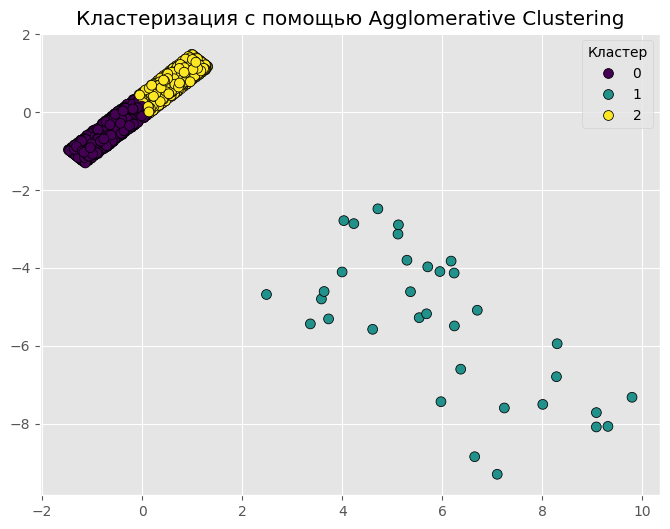

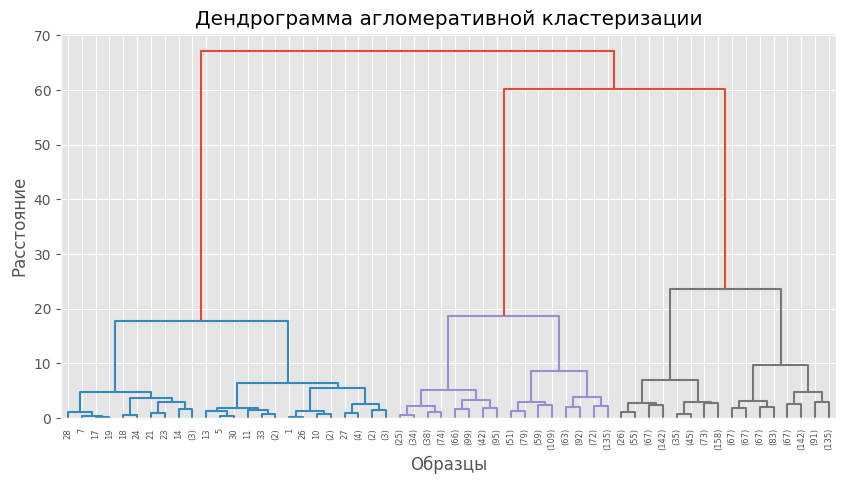

In [29]:
#Agglomerative clustering метод силуэтов
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

agg_clustering = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels = agg_clustering.fit_predict(X_pca)

# Визуализация результатов
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='viridis', s=50, edgecolor='k')
plt.title("Кластеризация с помощью Agglomerative Clustering")
plt.legend(title="Кластер")
plt.show()

# Построение дендрограммы
plt.figure(figsize=(10, 5))
Z = linkage(X_pca, method='ward')
dendrogram(Z, truncate_mode='level', p=5)
plt.title("Дендрограмма агломеративной кластеризации")
plt.xlabel("Образцы")
plt.ylabel("Расстояние")
plt.show()

In [30]:
data['Cluster'] = agg_clustering.labels_

cluster_stats = data.groupby('Cluster')[numeric_columns].mean()

print(cluster_stats)

         Customer Reference ID  Purchase Amount (USD)  Review Rating  Cluster
Cluster                                                                      
0                  4040.136364             102.575000       2.063636      0.0
1                  4042.029412            3290.176471       3.402941      1.0
2                  4040.273610             110.163283       4.048632      2.0


In [31]:
category_proportions = data.groupby('Cluster')['Item Purchased'].value_counts(normalize=True).unstack(fill_value=0)

# Выводим пропорции товаров по кластерам
print(category_proportions)

Item Purchased  Backpack      Belt    Blazer    Blouse     Boots    Bowtie  \
Cluster                                                                      
0               0.021212  0.025000  0.017424  0.018939  0.013636  0.015909   
1               0.000000  0.029412  0.029412  0.000000  0.058824  0.029412   
2               0.021183  0.027361  0.022948  0.021183  0.022948  0.012357   

Item Purchased  Camisole  Cardigan      Coat     Dress  ...  Swimsuit  \
Cluster                                                 ...             
0               0.027273  0.021970  0.017424  0.018182  ...  0.016667   
1               0.000000  0.029412  0.000000  0.000000  ...  0.029412   
2               0.021183  0.023831  0.023831  0.016770  ...  0.020300   

Item Purchased   T-shirt  Tank Top       Tie  Trench Coat  Trousers     Tunic  \
Cluster                                                                         
0               0.018182  0.022727  0.016667     0.018182  0.018182  0.024242   


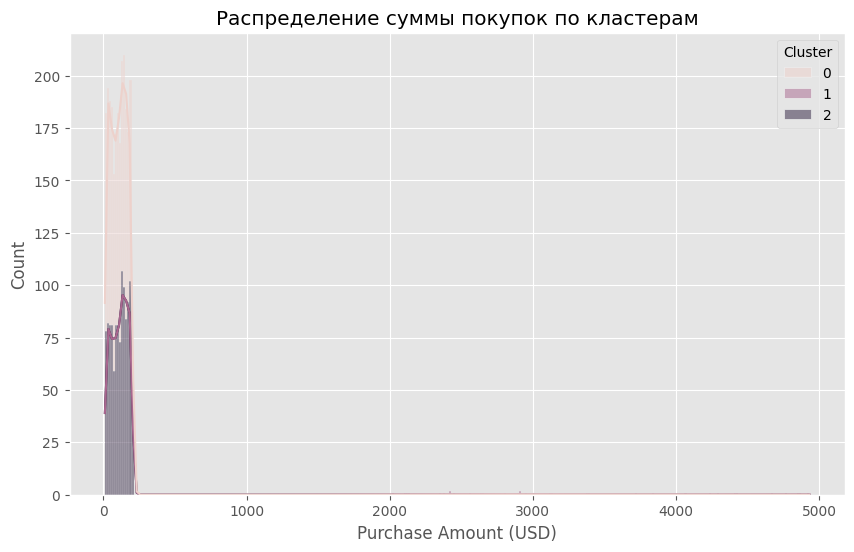

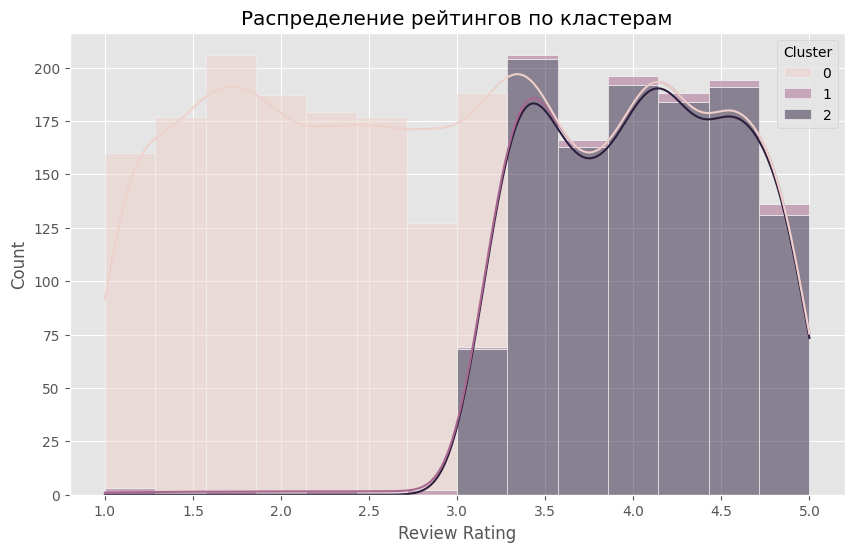

In [32]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='Purchase Amount (USD)', hue='Cluster', kde=True, multiple='stack')
plt.title('Распределение суммы покупок по кластерам')
plt.show()

# Гистограмма для рейтингов по кластерам
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='Review Rating', hue='Cluster', kde=True, multiple='stack')
plt.title('Распределение рейтингов по кластерам')
plt.show()

   Cluster Payment Method  count
0        0    Credit Card    687
1        0           Cash    633
2        1           Cash     18
3        1    Credit Card     16
4        2    Credit Card    600
5        2           Cash    533


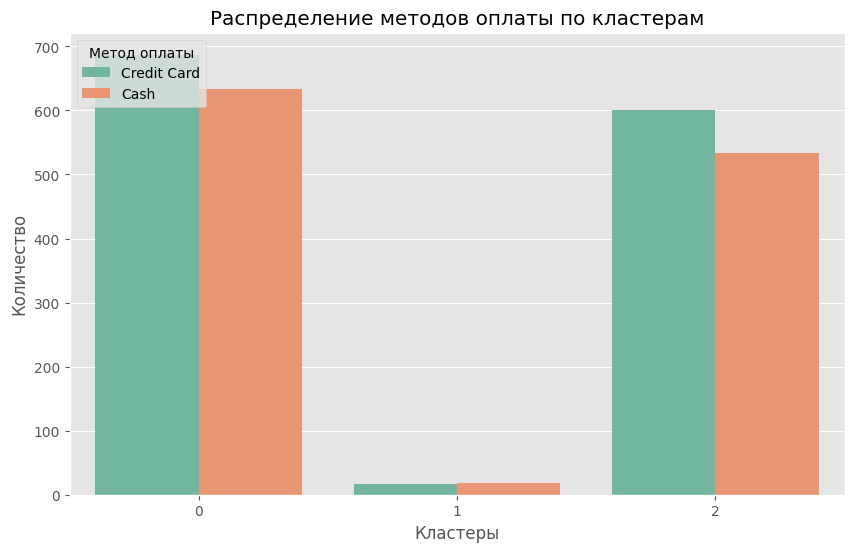

In [38]:
category_stats = data.groupby('Cluster')['Payment Method'].value_counts().reset_index(name='count')
print(category_stats)

plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='count', hue='Payment Method', data=category_stats, palette='Set2')
plt.title('Распределение методов оплаты по кластерам')
plt.xlabel('Кластеры')
plt.ylabel('Количество')
plt.legend(title='Метод оплаты', loc='upper left')
plt.show()

Review Category   High    Low  Medium
Cluster                              
0                  NaN  663.0   657.0
1                 14.0    7.0    13.0
2                579.0    NaN   554.0


<Figure size 1000x600 with 0 Axes>

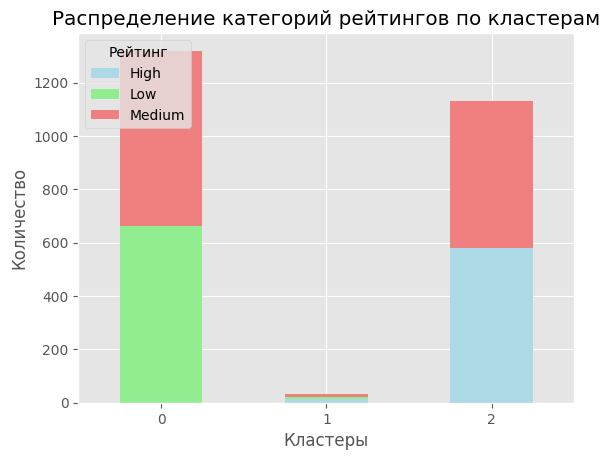

In [34]:
# Функция для категоризации рейтинга
def categorize_rating(rating):
    if pd.isna(rating):
        return 'No Rating'  # Если рейтинг отсутствует
    elif rating <= 2:
        return 'Low'
    elif rating <= 4:
        return 'Medium'
    else:
        return 'High'

# Применяем функцию к столбцу 'Review Rating'
data['Review Category'] = data['Review Rating'].apply(categorize_rating)

# Преобразуем данные для визуализации
payment_counts = data.groupby(['Cluster', 'Review Category']).size().unstack()
print(payment_counts)

# Визуализируем данные
plt.figure(figsize=(10, 6))
payment_counts.plot(kind='bar', stacked=True, color=['lightblue', 'lightgreen', 'lightcoral'])
plt.title('Распределение категорий рейтингов по кластерам')
plt.xlabel('Кластеры')
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.legend(title='Рейтинг', loc='upper left')
plt.show()

In [35]:
# Оценка метрик качества для Agglomerative Clustering
silhouette_spectral = silhouette_score(X_pca, labels)
calinski_spectral = calinski_harabasz_score(X_pca, labels)
davies_bouldin_spectral = davies_bouldin_score(X_pca, labels)

print("\nAgglomerative Clustering Метрики качества:")
print(f"Силуэтный коэффициент: {silhouette_spectral}")
print(f"Индекс Калински-Харабаса: {calinski_spectral}")
print(f"Индекс Дэвиса-Боулдина: {davies_bouldin_spectral}")


Agglomerative Clustering Метрики качества:
Силуэтный коэффициент: 0.5925895825013334
Индекс Калински-Харабаса: 5550.325533513877
Индекс Дэвиса-Боулдина: 0.4752585981453498


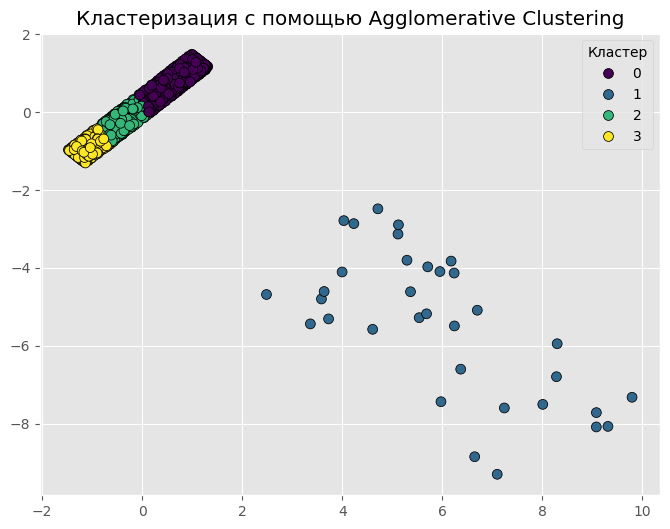

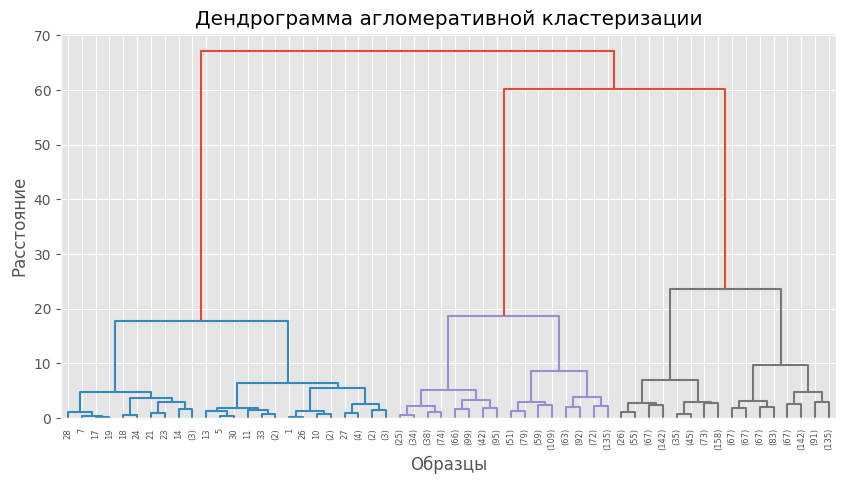

In [36]:
#Agglomerative clustering метод локтя
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

agg_clustering = AgglomerativeClustering(n_clusters=4, linkage='ward')
labels = agg_clustering.fit_predict(X_pca)

# Визуализация результатов
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='viridis', s=50, edgecolor='k')
plt.title("Кластеризация с помощью Agglomerative Clustering")
plt.legend(title="Кластер")
plt.show()

# Построение дендрограммы
plt.figure(figsize=(10, 5))
Z = linkage(X_pca, method='ward')
dendrogram(Z, truncate_mode='level', p=5)
plt.title("Дендрограмма агломеративной кластеризации")
plt.xlabel("Образцы")
plt.ylabel("Расстояние")
plt.show()

In [37]:
# Оценка метрик качества для Agglomerative Clustering метод локтя
silhouette_spectral = silhouette_score(X_pca, labels)
calinski_spectral = calinski_harabasz_score(X_pca, labels)
davies_bouldin_spectral = davies_bouldin_score(X_pca, labels)

print("\nAgglomerative Clustering Метрики качества:")
print(f"Силуэтный коэффициент: {silhouette_spectral}")
print(f"Индекс Калински-Харабаса: {calinski_spectral}")
print(f"Индекс Дэвиса-Боулдина: {davies_bouldin_spectral}")


Agglomerative Clustering Метрики качества:
Силуэтный коэффициент: 0.504854118622891
Индекс Калински-Харабаса: 5709.75338235287
Индекс Дэвиса-Боулдина: 0.5365904044528544
